Εράλντο Σινάνι 3677
Ιωάννης Μάρκου 3637

In [52]:
import pandas as pd
import json
import math
from tqdm import tqdm

from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture

from keybert import KeyBERT
from sentence_transformers import SentenceTransformer, util

import warnings
warnings.filterwarnings("ignore")

from numpy.linalg import norm
from operator import itemgetter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
DOC_SIZE = 100

#DOC_SIZE = DOC_SIZE - 1
docs = pd.read_csv("D:/dataForInfRetr/file.csv",
                       nrows=DOC_SIZE, encoding='utf-8')

file = []
for i in range(DOC_SIZE):
    file.append(docs.loc[i]['speech'])

# Documents size (in rows) = 1280918 (1,280,918)
# Columns = 11

In [54]:
for i in range(DOC_SIZE):
    print(docs.loc[i])

member_name                                   κρητικος νικολαου παναγιωτης
sitting_date                                                    03/07/1989
parliamentary_period                                              period 5
parliamentary_session                                            session 1
parliamentary_sitting                                            sitting 1
political_party                             πανελληνιο σοσιαλιστικο κινημα
government                    ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']
member_region                                                  β' πειραιως
roles                     ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']
member_gender                                                         male
speech                    Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...
Name: 0, dtype: object
member_name                                   κρητικος νικολαου παναγιωτης
sitting_date                                                    03/07/1989
pa

In [55]:
docs.loc[9]['speech']

" Κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας την Προεδρία του Σώματος θα ήθελα κατ' αρχήν να ευχαριστήσω όσους με ψήφισαν. Αλλά θα ήθελα να ευχαριστήσω επίσης και όσους δεν με εψήφισαν. Το τεκμήριο της δημοκρατικότητος και συνεπώς και της νομιμότητος μιας εκλογής δεν είναι μόνο οι θετικές, αλλά είναι και οι αρνητικές ψήφοι. Δεν είναι μόνο τα ΝΑΙ, αλλά και τα ΟΧΙ που πιστοποιούν ότι το σύστημα λειτουργεί. Ο Πρόεδρος της Βουλής δεν είναι βέβαια πρόσωπο υπερκομματικό. Προέρχεται από κάποια παράταξη. Ο ρόλος όμως που καλείται να παίξει στο πλαίσιο του πολιτεύματος είναι υπερκομματικός, αντικειμενικός και αμερόληπτος. Και στις απαιτήσεις αυτού του ρόλου είμαι αποφασισμένος να ανταποκριθώ στο ακέραιο! Δεν ξέρω πόσο θα διαρκέσει η θητεία μου. Όταν όμως θα τερματισθεί, η μεγαλύτερη ικανοποίηση για μένα θα είναι να αναγνωρισθεί από όλες τις Πτέρυγες του Κοινοβουλίου ότι δεν μερολήπτησα υπέρ ή εναντίον οποιουδήποτε κόμματος. Αποδίδω άλλωστε πρωταρχική σημασία στην ομαλή και αποτελεσματική λειτ

==========================================

In [56]:
file

[' Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να συνοδεύσει το Μακαριότατο Αρχιεπίσκοπο Αθηνών και πάσης Ελλάδος κ. ΣΕΡΑΦΕΙΜ και τα συνοδεύοντα αυτόν μέλη της Ιεράς Συνόδου κατά την είσοδό τους στην Αίθουσα της Βουλής, προκειμένου να τελεσθεί αγιασμός.  . Στη συνέχεια τελείται ο καθιερωμένος αγιασμός.',
 ' Παρακαλείται ο κύριος Γραμματέας να συνοδεύσει την Ιερά Σύνοδο εκτός της Αιθούσης της Βουλής.  . Παρακαλείται ο συνάδελφος Βουλευτής κ. Σαδίκ Αμέτ, που ανήκει στο Μωαμεθανικό Θρήσκευμα να προσέλθει και να δώσει τον οριζόμενο από το Σύνταγμα όρκο επί του Κορανίου.  : ~"Ορκίζομαι στο όνομα του Παντοδύναμου Θεού και του μόνου αυτού Προφήτη ο οποίος είναι ο Μωάμεθ να είμαι πιστός στην πατρίδα και το δημοκρατικό πολίτευμα, να υπακούω στο Σύνταγμα και τους νόμους και να εκπληρώνω ευσυνείδητα τα καθήκοντά μου".',
 ' Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσιοδοτήσει το Προεδρείο για την επικύρωση των Πρακτικών της σημερινής συνεδριάσεως.',
 ' Μάλιστα, μάλιστα.',
 ' Η Βουλή παρέσχε τη ζητη

In [57]:
# Remove the punctuation marks.
punc = '''!()-[]{};:'"\, <>./?@#$%^&*_`~'''
for i,line in enumerate(file):
    for ele in line: 
        if ele in punc: 
            line = line.replace(ele, " ") 
            
    file[i] = line

In [58]:
def saveToFile(filename, obj):
    try:
        f = open(filename,'w')
        jsonStr = json.dumps(obj)
        f.write(jsonStr)
        f.close()
        return True
    except:
        print("Error at saving the file")
        return False
    finally:
        f.close()
        
        
def loadFromFile(filename):
    try:
        f = open(filename,'r')
        jsonStr = f.read()
        obj = json.loads(jsonStr)
        f.close()
        return obj
    except:
        print("Error at loading the file")
        return -1
    finally:
        f.close()
        

==
=
==
=

In [59]:
merged = ""
for line in tqdm(file):
    merged += line
merged = merged.lower()

merged = " ".join(file)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100031.10it/s]


In [60]:
merged

' Παρακαλείται ο Γραμματέας κ  Βουλγαράκης να συνοδεύσει το Μακαριότατο Αρχιεπίσκοπο Αθηνών και πάσης Ελλάδος κ  ΣΕΡΑΦΕΙΜ και τα συνοδεύοντα αυτόν μέλη της Ιεράς Συνόδου κατά την είσοδό τους στην Αίθουσα της Βουλής  προκειμένου να τελεσθεί αγιασμός     Στη συνέχεια τελείται ο καθιερωμένος αγιασμός   Παρακαλείται ο κύριος Γραμματέας να συνοδεύσει την Ιερά Σύνοδο εκτός της Αιθούσης της Βουλής     Παρακαλείται ο συνάδελφος Βουλευτής κ  Σαδίκ Αμέτ  που ανήκει στο Μωαμεθανικό Θρήσκευμα να προσέλθει και να δώσει τον οριζόμενο από το Σύνταγμα όρκο επί του Κορανίου       Ορκίζομαι στο όνομα του Παντοδύναμου Θεού και του μόνου αυτού Προφήτη ο οποίος είναι ο Μωάμεθ να είμαι πιστός στην πατρίδα και το δημοκρατικό πολίτευμα  να υπακούω στο Σύνταγμα και τους νόμους και να εκπληρώνω ευσυνείδητα τα καθήκοντά μου    Κύριοι συνάδελφοι  παρακαλώ τη Βουλή να εξουσιοδοτήσει το Προεδρείο για την επικύρωση των Πρακτικών της σημερινής συνεδριάσεως   Μάλιστα  μάλιστα   Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότη

In [61]:
listStops = stopwords.words()
len(listStops)

10405

In [62]:
# Creating the inversed Cataloge
text_tokens = word_tokenize(merged)
text_tokens = list(dict.fromkeys(text_tokens))

In [63]:
len(text_tokens)

2768

In [64]:
def wordTokenizer(merged):
    quantity = 10000000
    times = (int)(len(merged) / quantity) + 1

    text_tokens = word_tokenize(merged[:quantity])
    text_tokens = list(dict.fromkeys(text_tokens))

    for i in tqdm(range(1,times)):
        v0 = i*(quantity)-100
        v1 = (i+1)*(quantity)
        tt = word_tokenize(merged[v0:v1])
        tt[0] = ""
        tt[len(tt)-1] = ""
        tt = list(dict.fromkeys(tt))
        text_tokens = text_tokens + tt
        text_tokens = list(dict.fromkeys(text_tokens))
    return text_tokens

In [65]:
wordTokenizer(merged)

0it [00:00, ?it/s]


['Παρακαλείται',
 'ο',
 'Γραμματέας',
 'κ',
 'Βουλγαράκης',
 'να',
 'συνοδεύσει',
 'το',
 'Μακαριότατο',
 'Αρχιεπίσκοπο',
 'Αθηνών',
 'και',
 'πάσης',
 'Ελλάδος',
 'ΣΕΡΑΦΕΙΜ',
 'τα',
 'συνοδεύοντα',
 'αυτόν',
 'μέλη',
 'της',
 'Ιεράς',
 'Συνόδου',
 'κατά',
 'την',
 'είσοδό',
 'τους',
 'στην',
 'Αίθουσα',
 'Βουλής',
 'προκειμένου',
 'τελεσθεί',
 'αγιασμός',
 'Στη',
 'συνέχεια',
 'τελείται',
 'καθιερωμένος',
 'κύριος',
 'Ιερά',
 'Σύνοδο',
 'εκτός',
 'Αιθούσης',
 'συνάδελφος',
 'Βουλευτής',
 'Σαδίκ',
 'Αμέτ',
 'που',
 'ανήκει',
 'στο',
 'Μωαμεθανικό',
 'Θρήσκευμα',
 'προσέλθει',
 'δώσει',
 'τον',
 'οριζόμενο',
 'από',
 'Σύνταγμα',
 'όρκο',
 'επί',
 'του',
 'Κορανίου',
 'Ορκίζομαι',
 'όνομα',
 'Παντοδύναμου',
 'Θεού',
 'μόνου',
 'αυτού',
 'Προφήτη',
 'οποίος',
 'είναι',
 'Μωάμεθ',
 'είμαι',
 'πιστός',
 'πατρίδα',
 'δημοκρατικό',
 'πολίτευμα',
 'υπακούω',
 'νόμους',
 'εκπληρώνω',
 'ευσυνείδητα',
 'καθήκοντά',
 'μου',
 'Κύριοι',
 'συνάδελφοι',
 'παρακαλώ',
 'τη',
 'Βουλή',
 'εξουσιοδοτήσει',

In [66]:
tokens_without_sw = [
    word for word in tqdm(text_tokens) if not word in stopwords.words()]
tokens_without_sw = list(dict.fromkeys(tokens_without_sw))

100%|█████████████████████████████████████████████████████████████████████████████| 2768/2768 [00:23<00:00, 120.27it/s]


In [67]:
#'D:/dataForInfRetr/tokens.txt'

In [68]:
# for 100 files, like 25 secs of running
dict1 = {}

for i in range(DOC_SIZE):
    check = file[i].lower()
    for item in tokens_without_sw:
     
        if item in check:
            if item not in dict1:
                dict1[item] = []

            if item in dict1:
                #dict1[item].append(i+1)

                fileTokenized = word_tokenize(check)
                counter = 0
                for word in fileTokenized:
                    if(item==word):
                        counter += 1

                if(counter>0):
                    dict1[item].append((i,counter))

In [69]:
# Tok-k mmethod
def topK(q,dict1,k):
    s = []
    docIndex = []

    for t in q:
        if t in dict1:
            listOfT = dict1[t]
            nt = len(listOfT)
            idf = math.log(1+(DOC_SIZE/nt))

            for f in listOfT:
                if f[0] in docIndex:
                    idx = docIndex.index(f[0])
                    tf = 1 + math.log(f[1])
                    s[idx] = s[idx] + tf*idf
                else:
                    s.append(0)
                    docIndex.append(f[0])
                    idx = docIndex.index(f[0])
                    #print(f[1])
                    tf = 1 + math.log(f[1])
                    s[idx] = s[idx] + tf*idf
    
    
    for i in range(len(s)):
        s[i] = s[i]/len(file[docIndex[i]-1])

    #sort
    n = len(s)
    swapped = False

    for i in range(n-1):
        for j in range(0, n-i-1):
            if s[j] < s[j + 1]:
                swapped = True
                s[j], s[j + 1] = s[j + 1], s[j]
                docIndex[j], docIndex[j + 1] = docIndex[j + 1], docIndex[j]                
        if not swapped:
            break;

    topk = []
    if(k > len(docIndex)):
        k = len(docIndex)
    for i in range(k):
        topk.append(docIndex[i])

    return topk

In [70]:
def topK2(q,dict1,k,file):
    s = []
    docIndex = []
    for t in q:
        if t in dict1:
            listOfT = dict1[t]
            nt = len(listOfT)
            idf = math.log(1+(DOC_SIZE/nt))

            for f in listOfT:
                if f[0] in docIndex:
                    idx = docIndex.index(f[0])
                    tf = 1 + math.log(f[1])
                    s[idx] = s[idx] + tf*idf
                else:
                    s.append(0)
                    docIndex.append(f[0])
                    idx = docIndex.index(f[0])
                    #print(f[1])
                    tf = 1 + math.log(f[1])
                    s[idx] = s[idx] + tf*idf
    
    
    for i in range(len(s)):
        s[i] = s[i]/len(file[docIndex[i]-1])

    #sort
    n = len(s)
    swapped = False

    for i in range(n-1):
        for j in range(0, n-i-1):
            if s[j] < s[j + 1]:
                swapped = True
                s[j], s[j + 1] = s[j + 1], s[j]
                docIndex[j], docIndex[j + 1] = docIndex[j + 1], docIndex[j]                
        if not swapped:
            break;

    topk = []
    if(k > len(docIndex)):
        k = len(docIndex)
    for i in range(k):
        topk.append(docIndex[i])

    return topk

In [71]:
def clearQuery(q):
    #katharizi to query
    for i,line in enumerate(file):
        for ele in q: 
            if ele in punc: 
                q = q.replace(ele, " ")

    q = word_tokenize(q)

    q_without_sw = []
    for i,word in enumerate(q):
        if not word in stopwords.words():
            q_without_sw.append(word)
    q = q_without_sw
    return q

In [72]:
q = clearQuery("ένα")
print(topK2(q,dict1,5,file))

[77, 48, 83, 81, 43]


In [73]:
dict1['της']

[(0, 2),
 (1, 2),
 (2, 1),
 (4, 1),
 (5, 1),
 (6, 4),
 (7, 6),
 (8, 4),
 (9, 13),
 (12, 1),
 (15, 2),
 (16, 5),
 (17, 13),
 (18, 9),
 (20, 10),
 (21, 2),
 (23, 1),
 (25, 3),
 (42, 1),
 (51, 1),
 (58, 2),
 (62, 1),
 (64, 14),
 (65, 3),
 (66, 4),
 (70, 4),
 (77, 15),
 (79, 4),
 (81, 26),
 (83, 28),
 (86, 1),
 (90, 2),
 (95, 5)]

== Ερώτημα 2
==

In [74]:
docsToMembers = {}

for i in range(DOC_SIZE):
    if docs.loc[i]['member_name'] not in docsToMembers:
        docsToMembers[docs.loc[i]['member_name']] = []
    
    docsToMembers[docs.loc[i]['member_name']].append(i)

In [75]:
docsToParties = {}

for i in range(DOC_SIZE):
    if docs.loc[i]['political_party'] not in docsToParties:
        docsToParties[docs.loc[i]['political_party']] = []
    
    docsToParties[docs.loc[i]['political_party']].append(i)

In [76]:
docsToPeriods = {}

for i in range(DOC_SIZE):
    if docs.loc[i]['parliamentary_period'] not in docsToPeriods:
        docsToPeriods[docs.loc[i]['parliamentary_period']] = []
    
    docsToPeriods[docs.loc[i]['parliamentary_period']].append(i)

In [77]:
#intersection of two lists
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [78]:
kw_model = KeyBERT(model = 'paraphrase-multilingual-MiniLM-L12-v2')

In [79]:
membersToPeriods = []
for member in docsToMembers:
    periodsToMember = []
    periodsToMember.append(member)
    for period in docsToPeriods:
        docsToPeriod = intersection(docsToMembers[member], docsToPeriods[period])
        mergedDocs = ""
        for doc in docsToPeriod:
            mergedDocs += file[doc]
        keywords = kw_model.extract_keywords(mergedDocs, keyphrase_ngram_range=(1, 1), stop_words=listStops)
        periodsToMember.append([period, keywords])   
    membersToPeriods.append(periodsToMember)

In [80]:
membersToPeriods

[['κρητικος νικολαου παναγιωτης',
  ['period 5',
   [('χαραλαμπόπουλος', 0.6476),
    ('σταθόπουλος', 0.6443),
    ('δραγασακης', 0.59),
    ('χατζηδημητριου', 0.5865),
    ('χατζηνικολάου', 0.5525)]]],
 [nan,
  ['period 5',
   [('μάλιστα', 0.7856),
    ('διαβάσετε', 0.7028),
    ('μας', 0.6247),
    ('τη', 0.5982)]]],
 ['τσαλδαρης κωνσταντινου αθανασιος',
  ['period 5',
   [('προεδρία', 0.5961),
    ('αντιπροέδρων', 0.5953),
    ('ψηφοδόχων', 0.5825),
    ('δημοκρατικότητος', 0.5714),
    ('ψήφισε', 0.5502)]]],
 ['τσοβολας κωνσταντινου δημητριος',
  ['period 5',
   [('πρόεδρε', 0.5431),
    ('ψηφοδέλτια', 0.4969),
    ('λευκά', 0.308),
    ('ούτε', 0.299),
    ('κύριε', 0.1703)]]],
 ['τζαννετακης πετρου τζαννης',
  ['period 5',
   [('προεδρικο', 0.5261),
    ('1989', 0.5192),
    ('ελληνικης', 0.4863),
    ('κυβερνησεως', 0.4752),
    ('δημοκρατιας', 0.4747)]]],
 ['αλευρας νικολαου ιωαννης',
  ['period 5',
   [('κοινοβουλευτικού', 0.5777),
    ('πρόεδρο', 0.5736),
    ('κοινοβουλευτικ

In [81]:
membersTopKeywords = []
for member in docsToMembers:
    mergedDocs = ""
    for doc in docsToMembers[member]:
        mergedDocs += file[doc]
    keywords = kw_model.extract_keywords(mergedDocs, keyphrase_ngram_range=(1, 1), stop_words=listStops) 
    membersTopKeywords.append([member, keywords])

In [82]:
membersTopKeywords

[['κρητικος νικολαου παναγιωτης',
  [('χαραλαμπόπουλος', 0.6476),
   ('σταθόπουλος', 0.6443),
   ('δραγασακης', 0.59),
   ('χατζηδημητριου', 0.5865),
   ('χατζηνικολάου', 0.5525)]],
 [nan,
  [('μάλιστα', 0.7856),
   ('διαβάσετε', 0.7028),
   ('μας', 0.6247),
   ('τη', 0.5982)]],
 ['τσαλδαρης κωνσταντινου αθανασιος',
  [('προεδρία', 0.5961),
   ('αντιπροέδρων', 0.5953),
   ('ψηφοδόχων', 0.5825),
   ('δημοκρατικότητος', 0.5714),
   ('ψήφισε', 0.5502)]],
 ['τσοβολας κωνσταντινου δημητριος',
  [('πρόεδρε', 0.5431),
   ('ψηφοδέλτια', 0.4969),
   ('λευκά', 0.308),
   ('ούτε', 0.299),
   ('κύριε', 0.1703)]],
 ['τζαννετακης πετρου τζαννης',
  [('προεδρικο', 0.5261),
   ('1989', 0.5192),
   ('ελληνικης', 0.4863),
   ('κυβερνησεως', 0.4752),
   ('δημοκρατιας', 0.4747)]],
 ['αλευρας νικολαου ιωαννης',
  [('κοινοβουλευτικού', 0.5777),
   ('πρόεδρο', 0.5736),
   ('κοινοβουλευτικός', 0.5684),
   ('πρόεδρε', 0.5499),
   ('προέδρου', 0.5472)]],
 ['εβερτ αγγελου μιλτιαδης',
  [('πρόεδρε', 0.6319),
   (

In [83]:
partiesToPeriods = []
for party in docsToParties:
    periodsToParties = []
    periodsToParties.append(party)
    for period in docsToPeriods:
        docsToPeriod = intersection(docsToParties[party], docsToPeriods[period])
        mergedDocs = ""
        for doc in docsToPeriod:
            mergedDocs += file[doc]
        keywords = kw_model.extract_keywords(mergedDocs, keyphrase_ngram_range=(1, 1), stop_words=listStops)
        periodsToParties.append([period, keywords])   
    partiesToPeriods.append(periodsToParties)

In [84]:
partiesToPeriods

[['πανελληνιο σοσιαλιστικο κινημα',
  ['period 5',
   [('χαραλαμπόπουλος', 0.6476),
    ('σταθόπουλος', 0.6443),
    ('δραγασακης', 0.59),
    ('χατζηδημητριου', 0.5865),
    ('χατζηνικολάου', 0.5525)]]],
 ['βουλη', ['period 5', [('μάλιστα', 0.8419)]]],
 ['νεα δημοκρατια',
  ['period 5',
   [('προεδρία', 0.5961),
    ('αντιπροέδρων', 0.5953),
    ('προεδρικό', 0.5867),
    ('ψηφοδόχων', 0.5825),
    ('προεκλογικά', 0.5823)]]],
 ['συνασπισμος της αριστερας των κινηματων και της οικολογιας',
  ['period 5',
   [('συζήτηση', 0.4763),
    ('πρόεδρε', 0.4175),
    ('χρειάζεται', 0.4014),
    ('συνηγορήσουμε', 0.3765),
    ('ανάγκη', 0.3399)]]]]

In [85]:
partiesTopKeywords = []
for member in docsToParties:
    mergedDocs = ""
    for doc in docsToParties[member]:
        mergedDocs += file[doc]
    keywords = kw_model.extract_keywords(mergedDocs, keyphrase_ngram_range=(1, 1), stop_words=listStops) 
    partiesTopKeywords.append([member, keywords])

In [86]:
partiesTopKeywords

[['πανελληνιο σοσιαλιστικο κινημα',
  [('χαραλαμπόπουλος', 0.6476),
   ('σταθόπουλος', 0.6443),
   ('δραγασακης', 0.59),
   ('χατζηδημητριου', 0.5865),
   ('χατζηνικολάου', 0.5525)]],
 ['βουλη', [('μάλιστα', 0.8419)]],
 ['νεα δημοκρατια',
  [('προεδρία', 0.5961),
   ('αντιπροέδρων', 0.5953),
   ('προεδρικό', 0.5867),
   ('ψηφοδόχων', 0.5825),
   ('προεκλογικά', 0.5823)]],
 ['συνασπισμος της αριστερας των κινηματων και της οικολογιας',
  [('συζήτηση', 0.4763),
   ('πρόεδρε', 0.4175),
   ('χρειάζεται', 0.4014),
   ('συνηγορήσουμε', 0.3765),
   ('ανάγκη', 0.3399)]]]

In [87]:
docTopKeywords = []
for doc in file:
    keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 1), stop_words=listStops)
    docTopKeywords.append(keywords)

In [88]:
docTopKeywords

[[('αρχιεπίσκοπο', 0.5791),
  ('βουλγαράκης', 0.5141),
  ('αθηνών', 0.4622),
  ('συνόδου', 0.4103),
  ('ιεράς', 0.4044)],
 [('προφήτη', 0.6178),
  ('βουλευτής', 0.5296),
  ('μωάμεθ', 0.5198),
  ('ιερά', 0.4991),
  ('σύνταγμα', 0.4483)],
 [('προεδρείο', 0.5201),
  ('επικύρωση', 0.4855),
  ('συνεδριάσεως', 0.3699),
  ('σημερινής', 0.3105),
  ('συνάδελφοι', 0.3004)],
 [('μάλιστα', 0.927)],
 [('συναίνεση', 0.5079),
  ('προέδρου', 0.4115),
  ('αύριο', 0.4076),
  ('εξουσιοδότηση', 0.3985),
  ('ώρα', 0.3862)],
 [('ψηφοδελτίων', 0.7669),
  ('ψηφοδόχο', 0.763),
  ('ψηφοφορία', 0.7415),
  ('ψήφισε', 0.6804),
  ('συναδέλφων', 0.275)],
 [('βουλευτής', 0.6258),
  ('ψηφοδόχου', 0.6137),
  ('ψηφίζει', 0.5993),
  ('ψηφοδέλτιο', 0.591),
  ('ψηφοδέλτια', 0.5704)],
 [('εψήφισε', 0.6643),
  ('ψηφοφορία', 0.664),
  ('ψηφοδελτίων', 0.662),
  ('κοινοβουλευτική', 0.6173),
  ('βουλευτές', 0.5649)],
 [('ψήφισαν', 0.7217),
  ('ψηφοδέλτια', 0.7124),
  ('ψήφους', 0.7102),
  ('ψηφοφορίας', 0.707),
  ('ψήφων', 0.703

== Ερώτημα 3
==

In [89]:
#######################################-top k zevgi-################################################3

In [90]:
# Tok-k similarity method
def topKSimilarMembers(docsToMembers,dict1,k):
    
    #gia na apofigoume to bag me ton voulefti NaN
    k=k+1
    
    membersVector = {}
    for member in docsToMembers:
        membersVector[member] = []
    
    for t in dict1:
        listOfT = dict1[t]
        nt = len(listOfT)
        idf = math.log(1+(DOC_SIZE/nt))
        
        for member in docsToMembers:
            counter = 0
            tf = 0
            for f in listOfT:
                if f[0] in docsToMembers[member]:
                    tf = tf + (1 + math.log(f[1]))/len(file[f[0]-1])
                    counter += 1
            if(counter==0):
                membersVector[member].append(0)
            else:
                membersVector[member].append(tf*idf/counter)
                
        

    
    buffer = []
    
    for a in membersVector:
        for b in membersVector:
            
            continueHelper = False
            for c in buffer:
                if c[0] == b and c[1] == a:
                    continueHelper = True
                    break
            if(continueHelper==True):
                continue
            
            if(a!=b):
                
                cosine = np.dot(membersVector[a],membersVector[b])/(norm(membersVector[a])*norm(membersVector[b]))
                if(len(buffer)<k):
                    buffer.append([a,b,cosine])
                else:
                    minCos = buffer[0][2]
                    minIndex = 0
                    for c in range(len(buffer)):
                        if(buffer[c][2]<minCos):
                            minCos = buffer[c][2]
                            minIndex = c

                    if(cosine>buffer[minIndex][2]):
                        buffer[minIndex] = [a,b,cosine]
    for i in buffer:
        if i[2]==1.0:
            buffer.remove(i)
        
    buffer = sorted(buffer, key=itemgetter(2), reverse=True)
        
    return buffer
    

In [91]:
print(topKSimilarMembers(docsToMembers,dict1,5))

[['μητσοτακης κυριακου κωνσταντινος', 'καππος βασιλειου κωνσταντινος', 0.1851054925121128], ['κρητικος νικολαου παναγιωτης', 'τσαλδαρης κωνσταντινου αθανασιος', 0.12144206660855987], ['τσαλδαρης κωνσταντινου αθανασιος', 'τζαννετακης πετρου τζαννης', 0.10362359190882466], ['αλευρας νικολαου ιωαννης', 'γεννηματας θεοδωρου γεωργιος', 0.08903475153024838], ['κυρκος μιχαηλ λεωνιδας', 'μητσοτακης κυριακου κωνσταντινος', 0.086317617211182]]


== LSA(Ερώτημα 4)
==

In [92]:
tfidf_vectorizer = TfidfVectorizer()
A = tfidf_vectorizer.fit_transform(file)
A = A.toarray()

In [93]:
A.shape

(100, 2578)

In [94]:
U, S, V = np.linalg.svd(A)

In [95]:
print(U.shape)
print(S.shape)
print(V.shape)

(100, 100)
(100,)
(2578, 2578)


In [96]:
print (S) # Concepts

[3.08742922e+00 2.25755271e+00 2.23606798e+00 1.87268872e+00
 1.63836295e+00 1.53453806e+00 1.47020837e+00 1.40962177e+00
 1.35315079e+00 1.32199285e+00 1.26232687e+00 1.24746994e+00
 1.22225035e+00 1.17559879e+00 1.17129649e+00 1.16122369e+00
 1.14548401e+00 1.13543229e+00 1.12918044e+00 1.12447114e+00
 1.10625880e+00 1.08340669e+00 1.07472515e+00 1.06551673e+00
 1.05836415e+00 1.04947381e+00 1.04097683e+00 1.02962301e+00
 1.01442758e+00 1.01137061e+00 1.00530923e+00 1.00000000e+00
 9.97727164e-01 9.86812314e-01 9.72268560e-01 9.61798981e-01
 9.60558360e-01 9.54254022e-01 9.39904309e-01 9.34974726e-01
 9.31552134e-01 9.23068889e-01 9.10700258e-01 8.97455098e-01
 8.94830526e-01 8.89620495e-01 8.78301377e-01 8.68660680e-01
 8.64624528e-01 8.61208833e-01 8.59138592e-01 8.53031185e-01
 8.47915291e-01 8.40145647e-01 8.32790850e-01 8.28737272e-01
 8.17537479e-01 8.12943404e-01 8.08537075e-01 8.02516648e-01
 7.99286277e-01 7.80117089e-01 7.78790974e-01 7.73794130e-01
 7.70010517e-01 7.665340

In [97]:
# keep the first N rows of V
concepts = 2
V2 = V[:concepts,:]
# the matrix after dimensionality reduction
M = np.dot(A,V2.transpose())

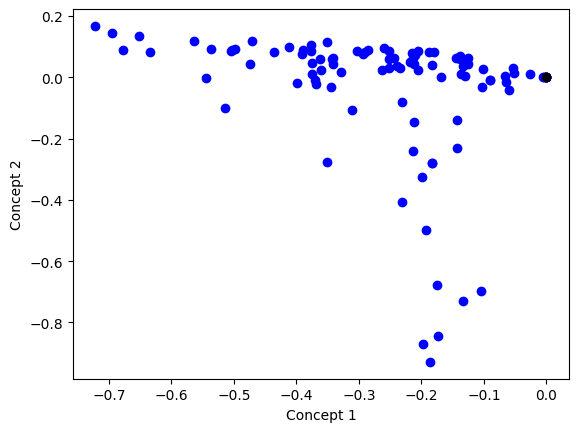

In [98]:
# plot the results
colors = ['blue','red','black','green','orange','brown']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(0,DOC_SIZE):
    ax.scatter(M[i,0],M[i,1], color='blue')
ax.scatter(0,0,color='black')    
plt.xlabel('SVD1')
plt.xlabel('Concept 1')
plt.ylabel('Concept 2') 
plt.show()

== CLUSTERING (Ερώτημα 5)
==

In [99]:
kmeans = KMeans(8) # Default

In [100]:
# Like 6-7 sec for 1000 data
cluster = kmeans.fit_transform(A)

In [101]:
kmeans.predict(A)

array([0, 0, 1, 4, 6, 0, 0, 0, 0, 0, 4, 6, 5, 2, 7, 0, 0, 0, 0, 0, 0, 7,
       7, 7, 7, 7, 3, 3, 3, 3, 2, 7, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 3,
       7, 7, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 3, 7, 0, 4, 6, 4, 5, 3, 0, 0,
       5, 3, 7, 1, 0, 1, 7, 1, 2, 3, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 0, 0,
       7, 2, 7, 7, 2, 6, 4, 5, 0, 7, 1, 2])

In [102]:
print(cluster[:10])
print('predicted: \n')
print(kmeans.predict(A[:10]))

[[0.9585844  1.15459892 1.05076775 1.06337724 1.41421356 1.17144295
  1.1858227  1.01146453]
 [0.88731277 1.14684649 1.03053132 1.04465702 1.41421356 1.1780289
  1.16491525 0.97395436]
 [0.97105699 0.94307576 1.05411006 1.05640272 1.41421356 1.12395243
  1.10269512 0.99103982]
 [1.10921499 1.16773183 1.07698414 1.07384752 0.         1.23502511
  1.22141742 1.05905485]
 [1.01289847 1.15380115 1.04958573 1.06071349 1.41421356 1.18175343
  0.64566627 1.0038267 ]
 [0.92088718 1.13918803 1.04742203 1.05271513 1.41421356 1.15275049
  1.18301475 0.98557705]
 [0.79806323 1.10030976 1.01483438 1.02506983 1.41421356 1.12383585
  1.12123804 0.95241417]
 [0.88561279 1.13014872 1.05005741 1.04824798 1.41421356 1.11457378
  1.16740742 0.99273493]
 [0.87100544 1.11939565 1.04708411 1.04955903 1.41421356 1.09541387
  1.15755489 0.99094674]
 [0.76456355 1.10376511 0.96048833 0.99038406 1.41421356 1.11527677
  1.11971328 0.8921194 ]]
predicted: 

[0 0 1 4 6 0 0 0 0 0]


In [103]:
# Birch
brc = Birch(n_clusters=None)

In [104]:
brc.fit(A)

Birch(n_clusters=None)

In [105]:
brc.predict(A)

array([ 1,  2,  3,  0,  4,  5,  6,  7,  8,  9,  0,  4, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 48, 49, 50, 19, 20, 51, 52, 53, 54, 55, 21, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 22, 66, 67, 23, 24, 68, 25, 69, 70,
       26, 27, 67, 71, 28, 72, 29, 30,  0, 31,  0, 10, 73, 32, 33, 34, 74,
       75, 76, 35, 36, 77, 36, 37, 78, 60,  9, 60, 38, 79, 39, 60, 40, 80,
       81, 41, 42, 43, 82, 44, 83, 45, 46,  0, 47, 84, 85, 86, 87])

In [106]:
brc1 = Birch(n_clusters=8)
brc1.fit_transform(A)
brc1.predict(A)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0, 0, 1, 0, 7,
       1, 2, 7, 7, 6, 2, 2, 2, 2, 7, 2, 2, 3, 3, 5, 2, 2, 2, 2, 2, 6, 2,
       1, 7, 3, 1, 7, 7, 7, 7, 3, 1, 3, 7, 3, 3, 0, 1, 0, 1, 0, 3, 0, 0,
       0, 1, 1, 3, 0, 5, 1, 5, 2, 7, 5, 0, 5, 0, 5, 0, 5, 0, 3, 6, 7, 0,
       4, 4, 4, 4, 4, 4, 1, 0, 1, 1, 5, 1], dtype=int64)